In [1]:
import os, sys
home = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__init__.py'))))
sys.path.append(home)

In [2]:
import optical_datasources as optx
import imgtools
import ee

In [3]:
ee.Initialize()

In [4]:
import pandas as pd

In [5]:
%matplotlib inline

# Get formatted DHS dataframe

This is just to understand better the distribution of the data within the DHS locations. This step is not necessary for the actual export.

In [6]:
dhsdf = pd.read_csv(os.path.join(home,'data', 'dhs_all_locations.csv'))

In [7]:
dhsdf.head()

,Unnamed: 0,cluster_index,lat,lon,wealth,wealthpooled,wealthpooled5country,households,urban_rural,year,country
0,0,1,14.675431,-17.440521,1.708104,1.598379,1.377751,21,1,2012,senegal
1,1,2,14.678271,-17.457794,1.679525,1.734295,1.449533,20,1,2012,senegal
2,2,3,14.710419,-17.459288,1.337672,1.421252,1.209425,21,1,2012,senegal
3,3,4,14.702820,-17.443008,2.443803,2.117576,1.828092,21,1,2012,senegal
4,4,5,14.757125,-17.478474,2.091719,1.848890,1.626253,22,1,2012,senegal


In [8]:
dhsdf.shape

(19671, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fbb5590>]], dtype=object)

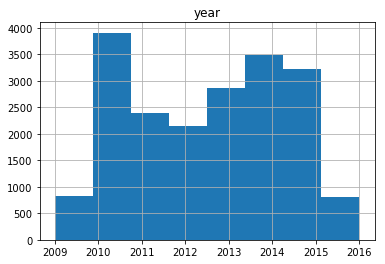

In [9]:
 dhsdf.hist('year', bins=8)

In [10]:
dfsmr = pd.DataFrame(dhsdf.groupby(['year','country']).size())

In [11]:
dfsmr2 = pd.DataFrame(dhsdf.groupby(['year']).size())

In [12]:
dfsmr2=dfsmr2.reset_index()

In [13]:
dfsmr2

,year,0
0,2009,835
1,2010,3906
2,2011,2389
3,2012,2140
4,2013,2865
5,2014,3495
6,2015,3227
7,2016,814


In [14]:
dfsmr2[dfsmr2['year'] <= 2011][0].sum()

7130

In [15]:
dfsmr2[(dfsmr2['year'] > 2011) & (dfsmr2['year'] <= 2014)][0].sum()

8500

In [16]:
dfsmr2[dfsmr2['year'] > 2014][0].sum()

4041

**Landsat launch dates are:**
 - Landsat 8: February 11, 2013 - current
 - Landsat 7: April 15, 1999 - current
 - Landsat 5: March 1, 1984 –  November 2011

Considering the distribution of data and the dates of the individual satellites, it would seem that a reasonable approach would be splitting into two 4-year groups. One from 2009 to 2012 (inclusive) the other one from 2013 to 2016 (inclusive). That way I'm splitting the "bad years" (mid 2012 to mid

# Get EE Feature Collection from DHS fusion table

NOTE: the 'dhs_all_locations.csv' file is uploaded to a Fusion Table, and lat/lon columns are set as the default location columns.

In [17]:
dhsfc = ee.FeatureCollection('ft:1lFCM5_0xgkHG2-dBKB2WCuQnFHCecO7z_4VOLrhA')

In [18]:
# dhsfc.first().getInfo()

In [19]:
dhsfc_oldest = dhsfc.filter(ee.Filter.lte('year', 2011))

dhsfc_middle = dhsfc.filter([ee.Filter.gt('year', 2011),
                            ee.Filter.lte('year', 2014)])

dhsfc_recent = dhsfc.filter(ee.Filter.gt('year', 2014))

In [20]:
dhsfc_oldest.size().getInfo()

7130

In [21]:
dhsfc_middle.size().getInfo()

8500

In [22]:
dhsfc_recent.size().getInfo()

4041

# Generate multi-year composites

In [23]:
selbands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']  # these are consistent for all Lx

### Recent branch

In [24]:
roi_recent = dhsfc_recent.geometry()
srcoll_recent = optx.LandsatSR(roi_recent, '2015-1-1', '2017-12-31').mergedqam
srmedian_recent = srcoll_recent.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_recent = imgtools.add_latlon(srmedian_recent)

### Middle Branch

In [25]:
roi_mid = dhsfc_middle.geometry()
srcoll_mid = optx.LandsatSR(roi_mid, '2012-1-1', '2014-12-31').mergedqam
# srcoll_older = srcoll_older.map(lambda img: imgtools.add_latlon(img))
srmedian_mid = srcoll_mid.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_mid = imgtools.add_latlon(srmedian_mid)

### Oldest Branch

In [26]:
roi_oldest = dhsfc_oldest.geometry()
srcoll_oldest = optx.LandsatSR(roi_oldest, '2009-1-1', '2011-12-31').mergedqam
# srcoll_older = srcoll_older.map(lambda img: imgtools.add_latlon(img))
srmedian_oldest = srcoll_oldest.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_oldest = imgtools.add_latlon(srmedian_oldest)

# Create TF records from DHS locations

In [27]:
from ai_io import ee_tf_exports as tfexp

### Testing single patch from composite

In [35]:
kern = ee.Kernel.square(5,'pixels')
# kern = ee.Kernel.square(127,'pixels')
patches_array = srmedian_recent.neighborhoodToArray(kern)
pt = ee.Feature(dhsfc_recent.first())
samplep = tfexp._sample_patch(pt, patches_array, 30)

### Exporting array patches (i.e. full tile in array form) from DHS locations

In [28]:
dhsinfo = dhsfc_recent.first().propertyNames().getInfo()

In [29]:
test = tfexp.get_array_patches(srmedian_mid, 30, 127, dhsfc_middle, 
                     True, True, selbands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2012-14_dhslocs_arrays_v2')

In [30]:
test = tfexp.get_array_patches(srmedian_recent, 30, 127, dhsfc_recent, 
                     True, True, selbands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2015-17_dhslocs_arrays_v2')

In [31]:
test = tfexp.get_array_patches(srmedian_oldest, 30, 127, dhsfc_oldest, 
                     True, True, selbands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2009-11_dhslocs_arrays_v2')

In [32]:
# test.getInfo()

### Exporting reduced patches (i.e. tile stats) from DHS locations

In [44]:
redubands = [item for sublist in [[b+'_mean', b+'_variance'] for b in selbands] for item in sublist]

In [45]:
redubands

['BLUE_mean',
 'BLUE_variance',
 'GREEN_mean',
 'GREEN_variance',
 'RED_mean',
 'RED_variance',
 'NIR_mean',
 'NIR_variance',
 'SWIR1_mean',
 'SWIR1_variance',
 'SWIR2_mean',
 'SWIR2_variance',
 'TEMP1_mean',
 'TEMP1_variance']

In [46]:
test = tfexp.get_reduced_patches(srmedian_mid, 30, 127, dhsfc_middle, 
                     True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2012-14_dhslocs_stats_v2')

In [47]:
test = tfexp.get_reduced_patches(srmedian_recent, 30, 127, dhsfc_recent, 
                     True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2015-17_dhslocs_stats_v2')

In [48]:
test = tfexp.get_reduced_patches(srmedian_oldest, 30, 127, dhsfc_oldest, 
                     True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
                     'LabeledPatches/', 'lx_median_2009-11_dhslocs_stats_v2')